In [27]:
import copy
import time
from os import listdir
from os.path import isfile, join
import imageio
import matplotlib
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from numpy import dot
from numpy.linalg import inv, norm, svd, solve
from mpl_toolkits.mplot3d import Axes3D
import pykitti
import open3d

Your function for odometry  (without plotting)

In [4]:
def get_point_cloud(dataset, pcs_step, take_each_n_point):
    pc_s = np.zeros((0, 3))
    shape_s = np.zeros(int(max_range/pcs_step))
    # Collect point clouds
    for i in np.arange(0, max_range, pcs_step):
        curr = dataset.poses[i][:, 3]
        # Select n points from i-th point cloud
        pc = dataset.get_velo(i)
        pc = pc[range(0, pc.shape[0], take_each_n_point)]
        # Transform from velodyne (X) to left camera coordinates (x): x = Tr * X
        Tr = dataset.calib.T_cam0_velo[:3, :]
        pc = np.array([dot(Tr, i) for i in pc])
        pc += curr[:3]
        pc_s = np.vstack((pc_s, pc))
        shape_s[int(i/pcs_step)] = int(pc.shape[0])
    return pc_s, shape_s

Modification: 

input: 1 raw point cloud 
output: 1 turned point cloud

In [6]:
def get_one_point_cloud_turned(dataset, n_cloud, take_each_n_point, centroid, rotated_centroid):
    curr = dataset.poses[n_cloud][:, 3]
    pc = dataset.get_velo(n_cloud)
    pc = pc[range(0, pc.shape[0], take_each_n_point)]
    print(pc)
    Tr = dataset.calib.T_cam0_velo[:3, :]
    pc = np.array([dot(Tr, i) for i in pc])
    pc += curr[:3]
    pc -= centroid
    pc_turned = pc * M+rotated_centroid
    return pc_turned

Modification 2:

Input: number of point cloud(i), level of filtered groung(filter_z)

Output: one point cloud without ground

In [7]:
def get_one_pcd_filtered(i=0, filter_z = 0):
    pc = get_one_point_cloud_turned(dataset, i, take_each_n_point, centroid, rotated_centroid)
    #print(pc)
    filtered_pc = []
    for j in range (0, pc.shape[0]):
        if (pc[j,2]>filter_z):
            filtered_pc.append(pc[j])
    filtered_pc= np.array(filtered_pc).reshape(-1,3)
    #print(filtered_pc.shape)
    points = np.array(filtered_pc[:, :3])
    pcd = open3d.PointCloud()
    pcd.points = open3d.Vector3dVector(points)
    return pcd

Your magic:
returns: trajectory, centroid, rotated_centroid, M

In [8]:
def get_trajectory(dataset):
    trajectory = np.zeros((0, 3))
    # Collect odometry
    for i in np.arange(0, max_range):
        curr = dataset.poses[i][:, 3]
        trajectory = np.vstack((trajectory, curr[:3]))
    return trajectory


def compute_z(X, Y, plane_coeffs):
    return plane_coeffs[0] * X + plane_coeffs[1] * Y + plane_coeffs[2]

def calculate_rotation_matrix(a, b):
    v = np.cross(a, b)
    c = np.dot(a, b)
    I = np.identity(3)
    vx = np.matrix([0, -v[2], v[1], v[2], 0, -v[0], -v[1], v[0], 0]).reshape((3, 3))
    return I + vx + np.matmul(vx, vx) / (1 + c)

def find_best_fitting_plane(trajectory):
    # First use SVD to find normal of plane and calculate transformation to z-oriented view
    # Center all points
    centroid = [trajectory[:, 0].sum() / trajectory.shape[0],
                trajectory[:, 1].sum() / trajectory.shape[0],
                trajectory[:, 2].sum() / trajectory.shape[0]]

    centered_trajectory = trajectory - centroid

    # Apply SVD
    u, s, vh = svd(centered_trajectory.T, full_matrices=True)

    # Normal
    normal = u[:, 2]

    # Applied in a way: dot(point, M)
    M = calculate_rotation_matrix(np.array([0, 0, 1]), normal)

    normal = np.array(*dot(normal, M).tolist())

    rotated_trajectory = centered_trajectory[:, :] * M
    rotated_centroid = np.array(*dot(centroid,M).tolist())

    trajectory = rotated_trajectory
    trajectory += rotated_centroid

    # Use least squares to find best fitting plane along z coordinate

    A = np.zeros((trajectory.shape[0], 3))
    A[0:, 0] = trajectory[0:, 0].reshape((trajectory.shape[0],))
    A[0:, 1] = trajectory[0:, 1].reshape((trajectory.shape[0],))
    A[0:, 2] = 1

    b = np.zeros((trajectory.shape[0], 1))
    b[0:, 0] = trajectory[0:, 2].reshape((trajectory.shape[0],))

    # ax + by + c = z
    # Here: a, b and c
    plane_coeffs = solve(dot(A.T, A), dot(A.T, b))

    lx = -100
    ly = -300
    ux = 150
    uy = 100
    num = 10

    base = np.array([0.0, 0.0, 0.0])
    base += rotated_centroid
    normal += rotated_centroid

    #ax.plot([base[0], normal[0]], [base[1], normal[1]], [base[2], normal[2]])

    X, Y = np.meshgrid(np.arange(lx, ux, (ux - lx) / num), np.arange(ly, uy, (uy - ly) / num))
    Z = compute_z(X, Y, plane_coeffs)

    #ax.plot_wireframe(X, Y, Z, color='dimgray')

    return trajectory, centroid, rotated_centroid, M

Function for finding clusters using sklearn Agglomerative clustering 

In [9]:
def get_one_clusters(pcd, plot = False):
    colors_arr = [[0,0,0], [0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    pc = np.asarray(pcd.points)
    ward = AgglomerativeClustering(clusters_per_pair, linkage='ward').fit(pc)
    label = ward.labels_
    pcds = []
    if (plot):
        fig = plt.figure()
        ax = p3.Axes3D(fig)
        for l in np.unique(label):
            ax.scatter(pc[label == l, 0], pc[label == l, 1], pc[label == l, 2],
                       color=plt.cm.jet(float(l) / np.max(label + 1)),
                       s=20, edgecolor='k')
            points = np.array(pc[label == l])
            pcd = open3d.PointCloud()
            pcd.points = open3d.Vector3dVector(points)
            pcds.append(pcd)
        plt.show()
    else:
        for l in np.unique(label):
            points = np.array(pc[label == l])
            pcd = open3d.PointCloud()
            pcd.points = open3d.Vector3dVector(points)
            pcd.paint_uniform_color(colors_arr[int(l)])

            pcds.append(pcd)
    return pcds

Main global variables

In [10]:
# Folder with data set
basedir = 'dataset'
# Sequence to use
sequence = '00'
# Amount of frames to download.
max_range = 100
# How frequently should we select point clouds
pcs_step = 1 #would be correct only if it is equal 1
# Get n points from each of point clouds
take_each_n_point = 1 #would be correct only if it is equal 1
# Load odometry and point clouds
dataset = pykitti.odometry(basedir, sequence, frames=range(0, max_range, 1))
trajectory = get_trajectory(dataset)
trajectory, centroid, rotated_centroid, M = find_best_fitting_plane(trajectory)

In [11]:
clusters_per_pair = 4 # more corectly to call this number of cluster per each cloud
voxel_size = 0.02
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
pcd = open3d.PointCloud()
prev = open3d.PointCloud()
for i in range (1,2):#just for show
    out = get_one_point_cloud_turned(dataset, 0,i,centroid, rotated_centroid)
    points = np.array(out[:, :3])
    pcd = open3d.PointCloud()
    pcd.points = open3d.Vector3dVector(points)
    pcds = get_one_clusters(get_one_pcd_filtered(0,0.5))
    open3d.draw_geometries(pcds)

[[ 5.2897942e+01  2.2989739e-02  1.9979945e+00  7.9999998e-02]
 [ 5.3750526e+01  1.9291429e-01  2.0269539e+00  0.0000000e+00]
 [ 5.3803116e+01  3.6183926e-01  2.0289137e+00  0.0000000e+00]
 ...
 [ 3.8401384e+00 -1.4381756e+00 -1.7735560e+00  3.4000000e-01]
 [ 3.8257158e+00 -1.4192016e+00 -1.7645701e+00  2.5000000e-01]
 [ 4.0923753e+00 -1.5071962e+00 -1.8955611e+00  0.0000000e+00]]
[[ 5.2897942e+01  2.2989739e-02  1.9979945e+00  7.9999998e-02]
 [ 5.3750526e+01  1.9291429e-01  2.0269539e+00  0.0000000e+00]
 [ 5.3803116e+01  3.6183926e-01  2.0289137e+00  0.0000000e+00]
 ...
 [ 3.8401384e+00 -1.4381756e+00 -1.7735560e+00  3.4000000e-01]
 [ 3.8257158e+00 -1.4192016e+00 -1.7645701e+00  2.5000000e-01]
 [ 4.0923753e+00 -1.5071962e+00 -1.8955611e+00  0.0000000e+00]]


Result:
Agglomerative doesn't provide reasonable objects.
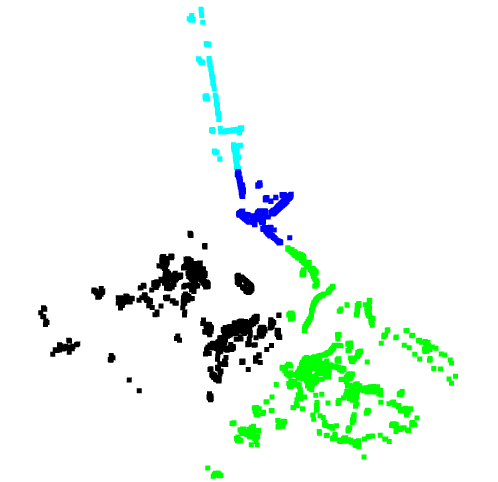

Function just to show how point clouds moves in time(with use of odometry, NO ICP, NO ground filter, no clusters)

In [53]:
def render_online():
    vis = open3d.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    render_option = vis.get_render_option()
    render_option.point_size = 1
    to_reset_view_point = True
    #prev = get_one_point_cloud_turned(dataset, 0, take_each_n_point, centroid, rotated_centroid)
    for j in range(0, max_range):
        pc = get_one_point_cloud_turned(dataset, j, take_each_n_point, centroid, rotated_centroid)
        points = np.array(pc[:, :3])
        pcd.points = open3d.Vector3dVector(points)
        vis.update_geometry()
        if to_reset_view_point:
            vis.reset_view_point(True)
            to_reset_view_point = False
        vis.poll_events()
        vis.update_renderer()
        depth = vis.capture_depth_float_buffer(False)
        image = vis.capture_screen_float_buffer(False)
        # TODO: Save images to files
        #plt.imsave("/home/kish/PycharmProjects/try/TestData/depth/{:05d}.png".format(j), \
        #           np.asarray(depth), dpi=1)
        #plt.imsave("/home/kish/PycharmProjects/try/TestData/image/{:05d}.png".format(j), \
        #           np.asarray(image), dpi=1)
        time.sleep(0.2)

In [ ]:
render_online()

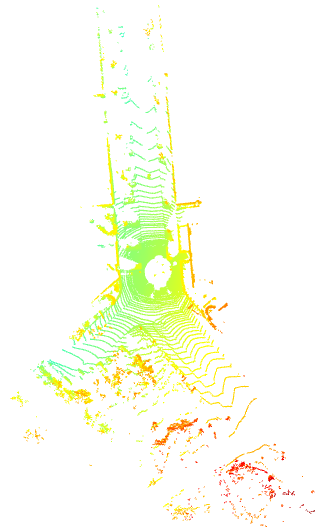

The same but without ground

In [13]:
def render_online_filtered(filter_z = 0):
    vis = open3d.Visualizer()
    vis.create_window()
    pcd = open3d.PointCloud()
    vis.add_geometry(pcd)
    render_option = vis.get_render_option()
    render_option.point_size = 1
    to_reset_view_point = True
    # prev = get_one_point_cloud_turned(dataset, 0, take_each_n_point, centroid, rotated_centroid)
    for j in range(0, max_range):
        points = get_one_pcd_filtered(j,filter_z).points
        pcd.points = open3d.Vector3dVector(points)
        vis.update_geometry()
        if to_reset_view_point:
            vis.reset_view_point(True)
            to_reset_view_point = False
        vis.poll_events()
        vis.update_renderer()
        depth = vis.capture_depth_float_buffer(False)
        image = vis.capture_screen_float_buffer(False)
        time.sleep(0.2)

In [ ]:
render_online_filtered()

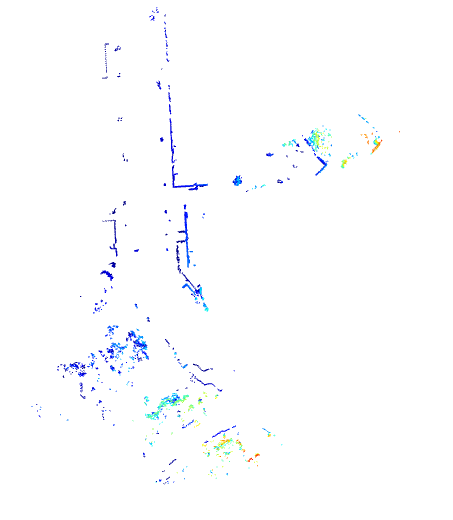

Render segments

With odometry, without ground, with clustering, without ICP

In [54]:
def render_online_segments(filter_z = 0):
    vis = open3d.Visualizer()
    vis.create_window()
    pcd = open3d.PointCloud()
    vis.add_geometry(pcd)
    render_option = vis.get_render_option()
    render_option.point_size = 10
    to_reset_view_point = True
    # prev = get_one_point_cloud_turned(dataset, 0, take_each_n_point, centroid, rotated_centroid)
    for j in range(0, max_range):
        pcds = get_one_clusters(get_one_pcd_filtered(j, filter_z))
        #points = get_one_pcd_filtered(j,filter_z).points
        #pcd.points = open3d.Vector3dVector(points)
        for f in range(0, len(pcds)):
            pcd.points = (pcds[f].points)

            #pcd.paint_uniform_color(pcds[f].paint_uniform_color)
            vis.update_geometry()
        if to_reset_view_point:
            vis.reset_view_point(True)
            to_reset_view_point = False
        vis.poll_events()
        vis.update_renderer()
        depth = vis.capture_depth_float_buffer(False)
        image = vis.capture_screen_float_buffer(False)
        # TODO: Save images to files
       # plt.imsave("/home/kish/PycharmProjects/try/TestData/depth/{:05d}.png".format(j), \
       #            np.asarray(depth), dpi=1)
       # plt.imsave("/home/kish/PycharmProjects/try/TestData/image/{:05d}.png".format(j), \
       #            np.asarray(image), dpi=1)
        time.sleep(1)
render_online_segments()

[[ 5.2897942e+01  2.2989739e-02  1.9979945e+00  7.9999998e-02]
 [ 5.3750526e+01  1.9291429e-01  2.0269539e+00  0.0000000e+00]
 [ 5.3803116e+01  3.6183926e-01  2.0289137e+00  0.0000000e+00]
 ...
 [ 3.8401384e+00 -1.4381756e+00 -1.7735560e+00  3.4000000e-01]
 [ 3.8257158e+00 -1.4192016e+00 -1.7645701e+00  2.5000000e-01]
 [ 4.0923753e+00 -1.5071962e+00 -1.8955611e+00  0.0000000e+00]]
[[ 5.2305943e+01  2.2989707e-02  1.9779946e+00  0.0000000e+00]
 [ 5.3259735e+01  1.0695236e-01  2.0099745e+00  0.0000000e+00]
 [ 5.3284321e+01  2.7487758e-01  2.0109341e+00  0.0000000e+00]
 ...
 [ 3.8249431e+00 -1.4261885e+00 -1.7655631e+00  2.3000000e-01]
 [ 3.8495324e+00 -1.4222100e+00 -1.7755738e+00  2.8999999e-01]
 [ 3.8631279e+00 -1.4142324e+00 -1.7805853e+00  0.0000000e+00]]
[[ 5.2575943e+01  2.2989839e-02  1.9869945e+00  0.0000000e+00]
 [ 7.4244514e+01  2.7688760e-01  2.7199390e+00  0.0000000e+00]
 [ 7.0721893e+01  5.9575552e-01  2.6008675e+00  0.0000000e+00]
 ...
 [ 3.8531775e+00 -1.4442681e+00 -1.780

KeyboardInterrupt: 

Not so fast.
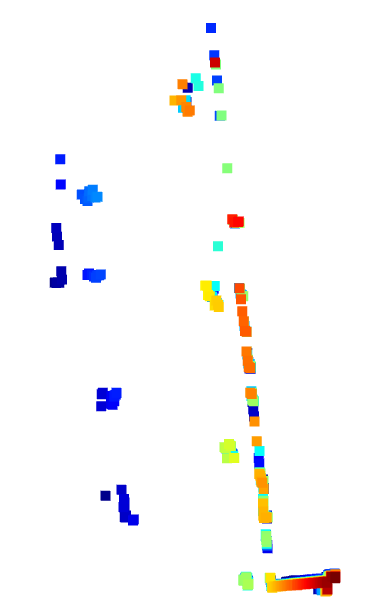

With ICP

In [14]:
def calc_prev_pcd(start, stop):
    vis = open3d.Visualizer()
    vis.create_window()
    pcd = open3d.PointCloud()
    prev = open3d.PointCloud()
    pre = get_one_point_cloud_turned(dataset, start, take_each_n_point, centroid, rotated_centroid)
    points = np.array(pre[:, :3])
    prev.points = open3d.Vector3dVector(points)
    vis.add_geometry(prev)
    render_option = vis.get_render_option()
    render_option.point_size = 1
    to_reset_view_point = True
    for j in range(start+1, stop):
        pc = get_one_point_cloud_turned(dataset, j, take_each_n_point, centroid, rotated_centroid)
        points = np.array(pc[:, :3])
        pcd.points = open3d.Vector3dVector(points)
        threshold = 0.02
        trans_init, info_init = pairwise_registration(pcd, prev)
        draw_registration_result(pcd, prev, trans_init)
        print("Initial alignment")
        evaluation = open3d.evaluate_registration(pcd, prev,
                                                  threshold, trans_init)
        print(evaluation)

        print("Apply point-to-point ICP")
        reg_p2p = open3d.registration_icp(pcd, prev, threshold, trans_init,
                                          open3d.TransformationEstimationPointToPoint())
        print(reg_p2p)
        print("Transformation is:")
        print(reg_p2p.transformation)
        print("")
        vis.update_geometry()
        if to_reset_view_point:
            vis.reset_view_point(True)
            to_reset_view_point = False
        vis.poll_events()

        vis.update_renderer(  draw_registration_result(pcd, prev, reg_p2p.transformation))
        image = vis.capture_screen_float_buffer(False)
        #plt.imsave("/home/kish/PycharmProjects/try/TestData/pairwise/{:05d}.png".format(j), \
        #           np.asarray(image), dpi=1)
        time.sleep(0.2)

        prev =  copy.deepcopy(pcd)

In [18]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = open3d.registration_icp(source, target,
            max_correspondence_distance_coarse, np.identity(4),
            open3d.TransformationEstimationPointToPlane())
    icp_fine = open3d.registration_icp(source, target,
            max_correspondence_distance_fine, icp_coarse.transformation,
            open3d.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = open3d.get_information_matrix_from_point_clouds(
            source, target, max_correspondence_distance_fine,
            icp_fine.transformation)
    return transformation_icp, information_icp
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    open3d.draw_geometries([source_temp, target_temp])

In [ ]:
calc_prev_pcd(0,5)

We take turned point clouds with odometry but ICP is still need
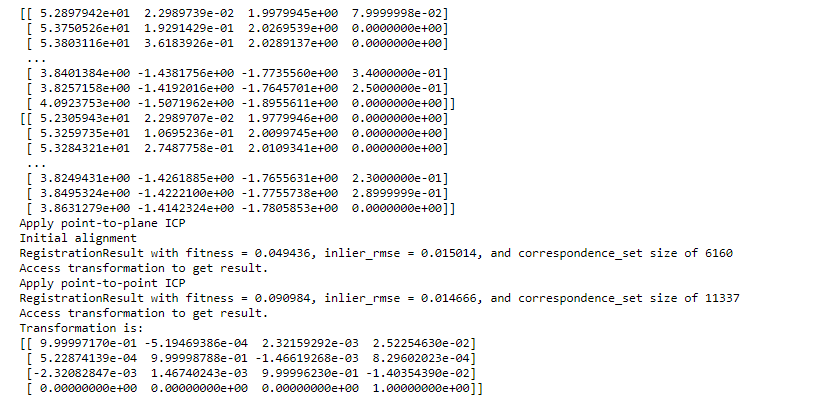

Just check that we do ICP correctly

ICP on pairs of point clouds 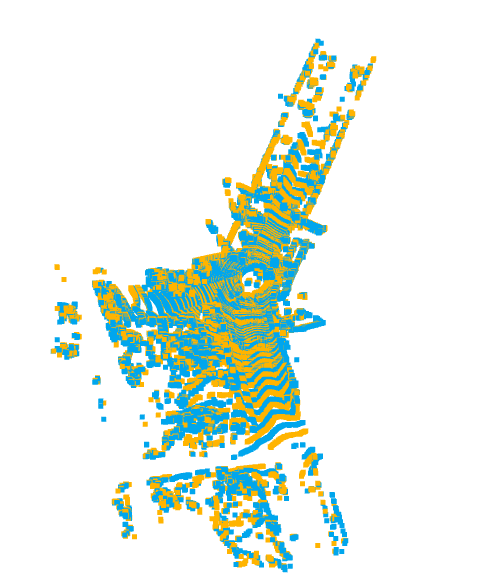

In [39]:
def pairwise_icp(pcd1, pcd2, threshold, draw = False):
    open3d.set_verbosity_level(open3d.VerbosityLevel.Debug)
    # just matrix I for the start
    trans_init = np.asarray(
        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0.0, 0.0, 0.0, 1.0]])
    # I've used downsample for faster calculations, but it is higly not recomended(by Gonzalo)
    #pcd1_down = open3d.voxel_down_sample(pcd1, voxel_size=voxel_size)
    #pcd2_down = open3d.voxel_down_sample(pcd2, voxel_size=voxel_size)
    #pcds_down = [pcd1_down, pcd2_down]
    pcd1_down = pcd1
    pcd2_down = pcd2
    evaluation = open3d.evaluate_registration(pcd1_down, pcd2_down,
                                       threshold, trans_init)
    #print(evaluation)
    reg_p2p = open3d.registration_icp(pcd1_down, pcd2_down, threshold, trans_init,
                               open3d.TransformationEstimationPointToPoint())
    if (draw):
        draw_registration_result(pcd1_down, pcd2_down, reg_p2p.transformation)
    return evaluation.fitness


Updated function for clustering with different techniques.
The suggested approach is to use weighted DBSCAN where weights depends of distances from pcd center to the point. This suggestion is my proposal for improvement of the algorithm


In [34]:
def get_one_clusters(pcd, plot = False, algoritm = "Agl", number = 0):
    colors_arr = [[0,0,0], [0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1], [2,0,0], [2,0,1], [2,0,2], [2,1,0], [2,1,1], [2,1,2], [2,2,0],[2,2,1], [2,2,2], [3,0,0], [3,0,1], [3,0,2], [3,0,3],[3,1,0], [3,1,1],[3,1,2],[3,1,3],[3,2,0],[3,2,1],[3,2,2], [3,2,3]]
    pc = np.asarray(pcd.points)
    if (algoritm=="Agl"):
        ward = AgglomerativeClustering(clusters_per_pair, linkage='ward').fit(pc)
        label = ward.labels_
    elif (algoritm == "DBSCAN"):
        #weights = calc_weights(get_one_point_cloud_turned(dataset, number, take_each_n_point, centroid, rotated_centroid),trajectory[number])
        #weights = calc_weights(np.asanyarray(pcd.points),trajectory[number])
        db = DBSCAN(eps=1, min_samples=5).fit(pc)#, sample_weight= weights)
        label = db.labels_
        n_clusters_ = len(set(label)) - (1 if -1 in label else 0)
        n_noise_ = list(label).count(-1)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)

    elif (algoritm == "Spectral"):
        clustering = SpectralClustering(n_clusters=clusters_per_pair, assign_labels = "discretize",
        random_state = 0).fit(pc)
        label = clustering.labels_
    else:
        print("not implemented error")
    pcds = []
    if (plot):
        fig = plt.figure()
        ax = p3.Axes3D(fig)
        for l in np.unique(label):
            if (l!=-1):
                ax.scatter(pc[label == l, 0], pc[label == l, 1], pc[label == l, 2],
                           color=plt.cm.jet(float(l) / np.max(label + 1)),
                           s=20, edgecolor='k')
                points = np.array(pc[label == l])
                pcd = open3d.PointCloud()
                pcd.points = open3d.Vector3dVector(points)
                pcds.append(pcd)
        plt.show()
    else:
        for l in np.unique(label):
            if (l != -1):
                points = np.array(pc[label == l])
                pcd = open3d.PointCloud()
                pcd.points = open3d.Vector3dVector(points)
               # print(colors_arr[int(l)])
                pcd.paint_uniform_color(colors_arr[int(l)])

                pcds.append(pcd)
    return pcds
def calc_weights(new_pcd, center):
    distances = []
    for i in range(0, new_pcd.shape[0]):
        distances.append(np.linalg.norm(new_pcd[i] - center))
    distances = np.array(distances)
    X = distances
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (X.max() - X.min()) + X.min()
    distances = np.array(X_scaled/X.max())
    return distances


In [41]:
# My approach for combination segments from 2 pcds. 
def get_joint_segments(pcds, pcds1, plot = False,  filter_z = 0.5):
    pairs = np.zeros((len(pcds), len(pcds1)))
    pcds_joint = []
    for i in range(0, len(pcds)):
        for j in range(0, len(pcds1)):
            pairs[i, j] = str(pairwise_icp(pcds[i], pcds1[j], filter_z, draw=False))
            if (pairs[i,j]>0.3):
                # join segments +down_sample+draw
                #TODO: add downsample, add pcds output and full render
                pcd_joint = [pcds[i], pcds1[j]]
                pcd_combined = open3d.PointCloud()
                for point_id in range(len(pcd_joint)):
                    #pcds[point_id].transform(pose_graph.nodes[point_id].pose)
                    pcd_combined += pcd_joint[point_id]

                pcd_combined_down = open3d.voxel_down_sample(pcd_combined, voxel_size=0.0001)
                #TODO: add posegraph combination
                pcds_joint.append(pcd_combined_down)
                if (plot):
                    open3d.draw_geometries(pcd_combined_down)
    segments =  []
    for i in range(0, pairs.shape[1]):
        segment_size = 0
        for j in range(0, pairs.shape[0]):
            if (pairs[j,i]>0.5):
                segment_size+=1
                if (plot):
                    (pairwise_icp(pcds[i], pcds1[j], filter_z, draw=True))
        segments.append(segment_size)
    return pairs, np.array(segments), pcds_joint

In [56]:
def get_joint_pairs(pcds, pcds1, plot = False,  filter_z = 0.5):
    pairs = np.zeros((len(pcds), len(pcds1)))
    pcds_joint = []
    for i in range(0, len(pcds)):
        for j in range(0, len(pcds1)):
            pairs[i, j] = str(pairwise_icp(pcds[i], pcds1[j], filter_z, draw=False))
            if (pairs[i,j]>0.5):
                # join segments +down_sample+draw
                #TODO: add downsample, add pcds output and full render
                pcd_joint = [pcds[i], pcds1[j]]
                pcd_combined = open3d.PointCloud()
                for point_id in range(len(pcd_joint)):
                    #pcds[point_id].transform(pose_graph.nodes[point_id].pose)
                    pcd_combined += pcd_joint[point_id]

                pcd_combined_down = open3d.voxel_down_sample(pcd_combined, voxel_size=0.0001)
                #TODO: add posegraph combination
                pcds_joint.append(pcd_combined_down)
                if (plot):
                    open3d.draw_geometries(pcd_combined_down)
    for i in range(0, pairs.shape[0]):
        if (pairs[i].min() == 0):
            pcds_joint.append(pcds[i])
    for i in range(0, pairs.shape[1]):
        if (pairs[:,i].min() == 0):
            pcds_joint.append(pcds1[i])
    return pairs, pcds_joint

In [46]:
# implementation of visualisation for case with aligned segments 

def custom_draw_geometry(j=0, saveF = True, filter_z = 0.5):
    vis = open3d.Visualizer()
    vis.create_window()
    pcds = get_one_clusters(get_one_pcd_filtered(0, filter_z))

    # open3d.draw_geometries(pcds)
    for i in range(0, len(pcds)):
        vis.add_geometry(pcds[i])
    if (j>0):
        for f in range(0,j):
            pcds = get_one_clusters(get_one_pcd_filtered(f, filter_z))

            # open3d.draw_geometries(pcds)
            #TODO: change labels!  change overloading
            for i in range (0, len(pcds)):
                vis.add_geometry(pcds[i])
            #vis.run()

            #vis.destroy_window()
            vis.poll_events()
            vis.update_renderer()
            image = vis.capture_screen_float_buffer(True)
            # TODO: Save images to files

            if (saveF):
                plt.imsave("/home/kish/PycharmProjects/try/TestData/image/{:05d}.png".format(f), \
                       np.asarray(image), dpi=1)

            time.sleep(0.2)
        vis.destroy_window()
def custom_draw_joint_geometry(pcds, saveF = False, number = 0, show = True, j = 0):
    vis = open3d.Visualizer()
    vis.create_window()

    # open3d.draw_geometries(pcds)
    for i in range(0, len(pcds)):
        vis.add_geometry(pcds[i])
    vis.poll_events()
    vis.reset_view_point(True)
    vis.get_render_option()
    vis.update_renderer()
    #ctr = vis.get_view_control()
    image = vis.capture_screen_float_buffer(True)
  
    if (saveF):
        plt.imsave("/home/kish/PycharmProjects/try/TestData/new/{:05d}.png".format(number), \
                   np.asarray(image), dpi=1)
    if(show):
        vis.run()
        vis.destroy_window()


In [57]:
# There were 2 ideas how to combine pcds, here we added aligned segments into array. It's higly computationally grows with number of
#steps but who cares 
def pairs_maximized(a,b, algoritm, show = False):
    pcds = get_one_clusters(get_one_pcd_filtered(a, filter_z=0.5), algoritm=algoritm, number=a)
    pcds1 = copy.deepcopy(get_one_clusters(get_one_pcd_filtered(a + 1, filter_z=0.5), algoritm=algoritm, number=a+1))
    _, _, pcds_out_prev = (get_joint_segments(pcds, pcds1, plot=False))
    custom_draw_joint_geometry(pcds_out_prev, saveF=False, number=a, show=show)
    for i in range(a+2,b,2):

        pcds = get_one_clusters(get_one_pcd_filtered(i, filter_z=0.5), algoritm=algoritm, number=i)
        pcds1 = copy.deepcopy(get_one_clusters(get_one_pcd_filtered(i + 1, filter_z=0.5), algoritm=algoritm, number=i+1))
        _,_, pcds_out = (get_joint_segments(pcds, pcds1, plot=False))
        #custom_draw_joint_geometry(pcds_out, saveF=True, number=i)
        _,pcds_out_prev = get_joint_pairs(pcds_out,pcds_out_prev)
        #print(pcds_out_prev)
        custom_draw_joint_geometry(pcds_out_prev, saveF=False, number=i+1, show= show)

pairs_maximized(0,10, algoritm="Agl", show=True)

[[ 5.2897942e+01  2.2989739e-02  1.9979945e+00  7.9999998e-02]
 [ 5.3750526e+01  1.9291429e-01  2.0269539e+00  0.0000000e+00]
 [ 5.3803116e+01  3.6183926e-01  2.0289137e+00  0.0000000e+00]
 ...
 [ 3.8401384e+00 -1.4381756e+00 -1.7735560e+00  3.4000000e-01]
 [ 3.8257158e+00 -1.4192016e+00 -1.7645701e+00  2.5000000e-01]
 [ 4.0923753e+00 -1.5071962e+00 -1.8955611e+00  0.0000000e+00]]
[[ 5.2305943e+01  2.2989707e-02  1.9779946e+00  0.0000000e+00]
 [ 5.3259735e+01  1.0695236e-01  2.0099745e+00  0.0000000e+00]
 [ 5.3284321e+01  2.7487758e-01  2.0109341e+00  0.0000000e+00]
 ...
 [ 3.8249431e+00 -1.4261885e+00 -1.7655631e+00  2.3000000e-01]
 [ 3.8495324e+00 -1.4222100e+00 -1.7755738e+00  2.8999999e-01]
 [ 3.8631279e+00 -1.4142324e+00 -1.7805853e+00  0.0000000e+00]]
[[ 5.2575943e+01  2.2989839e-02  1.9869945e+00  0.0000000e+00]
 [ 7.4244514e+01  2.7688760e-01  2.7199390e+00  0.0000000e+00]
 [ 7.0721893e+01  5.9575552e-01  2.6008675e+00  0.0000000e+00]
 ...
 [ 3.8531775e+00 -1.4442681e+00 -1.780

Aligned segments 
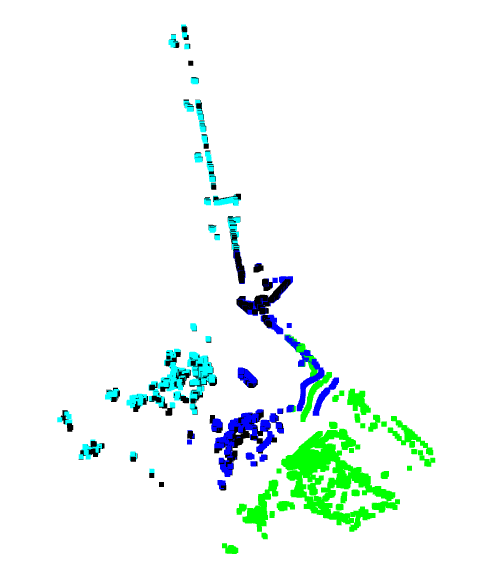

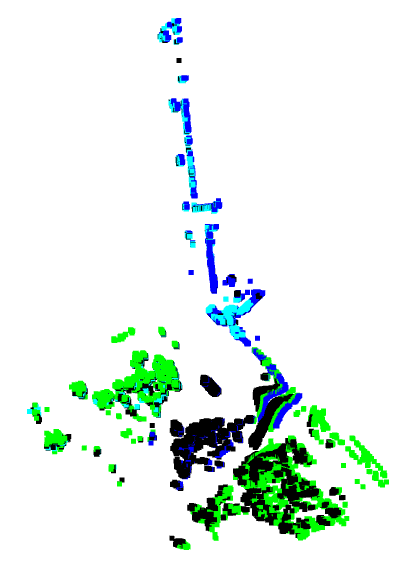

10 pcds with odometry, ground filtering, Agglomerative segmantation and ICP over pairs of segments
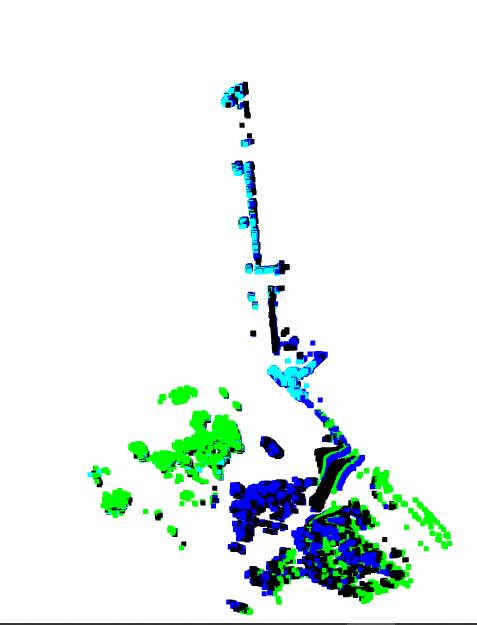